# Επιστημονική Python

**This notebook is heavily infuenced by the work of Luke Polson ([check here](https://github.com/lukepolson))**

## Προσαρμογή καμπύλης στα δεδομένα (curve fitting)

Η προσαρμογή κάποιας καμπύλης στα πειραματικά σας δεδομένα είναι από τις πιο σημαντικές δεξιότητες που θα πρέπει να αποκτήσετε στη διάρκεια των σπουδών σας. Με αυτόν τον τρόπο μπορείτε να βρείτε ποιό θεωρητικό μοντέλο περιγράφει καλύτερα τα δεδομένα σας και βάσει αυτού μπορείτε να κάνετε προβλέψεις για κάποιο άλλο σύνολο δεδομένων.

**Σκοπός της προσαρμογής συνάρτησης**

Όταν σας δίνονται κάποια $x_{\rm data} = [\dots]$, $y_{\rm data} = [\dots]$ και ένα θεωρητικό μοντέλο που περιγράφεται από τη συνάρτηση $f$ η οποία εξαρτάται από κάποιες άγνωστες παραμέτρους $\beta$, ο σκοπός είναι να βρούμε τον καλύτερο δυνατό συνδυασμό των παραμέτρων $\beta$ ώστε η συνάρτηση $y = f(x, \beta)$ να έχει παρόμοια συμπεριφορά με τα δεδομένα μας (δηλαδή να τα περιγράφει με καλή ακρίβεια).

- Ένας τρόπος να το επιτύχουμε αυτό είναι να ελαχιστοποιήσουμε την ποσότητα $\sum_n \left(f(x_n, \beta) - y_n \right)^2$ με το να προσαρμόζουμε τις παραμέτρους $\beta$. Εδώ, τα $x_n$ και $y_n$ είναι το n-οστό σημείο στα δεδομένα μας. Αυτή τη τεχνική ονομάζεται *μέθοδος των ελαχίστων τετραγώνων*.


- Εάν το σύνολο δεδομένων που περιέχει τα $y_n$ συνοδεύεται από τις αντίστοιχες αβεβαιότητες για αυτές τις τιμές, τότε μπορούμε να προσπαθήσουμε να ελαχιστοποιήσουμε την ποσότητα $\sum_n \left(f(x_n, \beta) - y_n \right)^2 / \sigma_n^2$. Αυτή μας δίνει τη *μέγιστη πιθανότητα* (maximum-likelihood) για την εκτίμηση των παραμέτρων $\beta$. Έτσι, δωθέντων των $x_n$ και $y_n$, οι τιμές των $\beta$ που πήραμε μέσω αυτής της μεθόδου είναι ο πιο πιθανός συνδυασμός.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as so

In [2]:
# Let's look at some sample data
x_data = np.array([0., 0.15789474, 0.31578947, 0.47368421, 0.63157895,
       0.78947368, 0.94736842, 1.10526316, 1.26315789, 1.42105263,
       1.57894737, 1.73684211, 1.89473684, 2.05263158, 2.21052632,
       2.36842105, 2.52631579, 2.68421053, 2.84210526, 3.])

y_data = np.array([2.95258285,   2.49719803,  -2.1984975 ,  -4.88744346,
        -7.41326345,  -8.44574157, -10.01878504, -13.83743553,
       -12.91548145, -15.41149046, -14.93516299, -13.42514157,
       -14.12110495, -17.6412464 , -16.1275509 , -16.11533771,
       -15.66076021, -13.48938865, -11.33918701, -11.70467566])

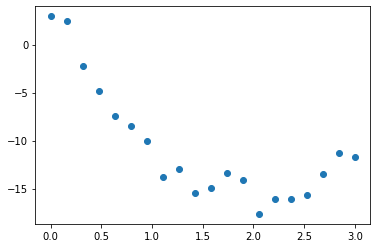

In [3]:
_ = plt.scatter(x_data,y_data)

Η μορφή της κατανομής των δεδομένων μας θυμίζει αρκετά ένα πολυώνυμο δευτέρου βαθμού. Είναι λογικό, λοιπόν, να θεωρήσουμε ότι ένα πολυώνυμο της μορφής

$$f(x, \beta) = f(x,a,b,c) = a(x-b)^2 + c$$

όπου $\beta = (a,b,c)$, αποτελεί ένα ικανοποιητικό θεωρητικό μοντέλο που μπορεί να περιγράψει την κατανομή των δεδομένων μας. Αυτό που πρέπει να προσδιορίσουμε τώρα είναι για **ποιές τιμές των $a$, $b$ και $c$** το παραπάνω θεωρητικό μοντέλο έχει την καλύτερη δυνατή συμπεριφορά που ταιριάζει στα δεδομένα μας.

Αυτό προϋποθέτει δύο βήματα:

1. Να ορίσουμε τη συνάρτηση του θεωρητικού μοντέλου.

2. Να χρησιμοποιήσουμε τη συνάρτηση ``curve_fit`` που παρέχεται από τη βιβλιοθήκη ``scipy.optimize``. Αυτή η συνάρτηση απαιτεί να δώσουμε κάποιες αρχικές τιμές για τις παραμέτρους $\beta$, κάτι που πρέπει να γίνει με προσοχή όταν έχουμε πολύπλοκα μοντέλα, αλλιώς η συνάρτηση μπορεί να μην δώσει αξιόπιστα αποτελέσματα.

In [4]:
# Define the function that describes the 
# theoretical model
def polynomial_model(x, a, b, c):
    """A second order polynomial function"""
    return a*(x-b)**2 + c

In [5]:
# Fit the theoretical curve on our data
popt, pcov = so.curve_fit(polynomial_model, x_data, y_data)

Η συνάρτηση ``curve_fit`` επιστρέφει δύο πίνακες:

1. τον πίνακα ``popt``, που περιέχει τις βέλτιστες τιμές για τις παραμέτρους $\beta$ του μοντέλου ``polynomial_model``, για τα συγκεκριμένα σύνολα δεδομένων ``x_data`` και ``y_data``.

In [6]:
popt

array([  4.92207992,   2.00492121, -16.04690266])

In [7]:
print("a = %f" % (popt[0]))
print("b = %f" % (popt[1]))
print("c = %f" % (popt[2]))

a = 4.922080
b = 2.004921
c = -16.046903


In [8]:
print("a = {} \nb = {} \nc = {}".format(*popt))

a = 4.922079922602843 
b = 2.004921210691221 
c = -16.04690266030743


2. τον πίνακα ``pcov``. Αυτός ο πίνακας ονομάζεται **πίνακας συνδιακύμανσης** (covariance matrix) και μας δίνει μία εκτίμηση για το σφάλμα των παραμέτρων που περιέχει ο πίνακας ``popt`` (δηλαδή των παραμέτρων $\beta = (a,b,c)$ και πόσο καλή είναι η προσαρμογή της θεωρητικής καμπύλης στα δεδομένα μας). Το "σφάλμα" σε κάθε μία από τις παραμέτρους του μοντέλου μας συνδέεται με το πόσο ευαίσθητο είναι το μοντέλο μας σε αλλαγές αυτής της παραμέτρου. Επίσης, μας δίνει πληροφορίες σχετικά με τον ποιό τρόπο εξαρτώνται οι παράμετροι της προσαρμογής $\beta$ μεταξύ τους.

In [9]:
pcov

array([[ 0.12827821, -0.01315915, -0.07363194],
       [-0.01315915,  0.00222114,  0.00322289],
       [-0.07363194,  0.00322289,  0.13377697]])

Παρατηρήστε ότι ο πίνακας συνδιακύμανσης είναι δισδιάστατος: **τα διαγώνια στοιχεία του πίνακα αφορούν το σφάλμα (διακύμανση-variance) για κάθε μία από τις παραμέτρους προσαρμογής** και τα μη-διαγώνια στοιχεία αφορούν τη σχέση μεταξύ των παραμέτρων. 

Η τετραγωνική ρίζα της διακύμανσης θα μας δώσει τα αντίστοιχα $1\sigma$-σφάλματα.

In [10]:
p_sigma = np.sqrt(np.diag(pcov))
p_sigma

array([0.35815948, 0.04712895, 0.36575534])

In [11]:
print("a = %f +/- %f" % (popt[0], p_sigma[0]))
print("b = %f +/- %f" % (popt[1], p_sigma[1]))
print("c = %f +/- %f" % (popt[2], p_sigma[2]))

a = 4.922080 +/- 0.358159
b = 2.004921 +/- 0.047129
c = -16.046903 +/- 0.365755


Έχοντας αποκτήσει τις βέλτιστες τιμές για τις παραμέτρους προσαρμογής, μπορούμε να φτιάξουμε ένα διάγραμμα όπου θα φαίνονται τα πειραματικά μας δεδομένα και η καμπύλη προσαρμογής. Αυτό θα μας βοηθήσει να δούμε το πόσο καλά το θεωρητικό μοντέλο που επιλέξαμε περιγράφει τα δεδομένα που έχουμε.

Για να κατασκευάσουμε την καμπύλη προσαρμογής, πρέπει να φτιάξουμε ένα διάστημα τιμών για τον $x$-άξονα. Εφόσον θέλουμε να έχουμε τοσο την καμπύλη προσαρμογής όσο και τα δεδομένα στο ίδιο γράφημα, πρέπει αυτό το διάστημα τιμών να έχει το ίδιο εύρος με αυτό των δεδομένων.

In [12]:
# Unpack the fitting parameters
a_opt, b_opt, c_opt = popt

# Create the x-axis intervals
x_model = np.linspace(min(x_data), max(x_data), 100)

# and the y-values from the theoretical model
# that correspond to this interval
y_model = polynomial_model(x_model, a_opt, b_opt, c_opt)

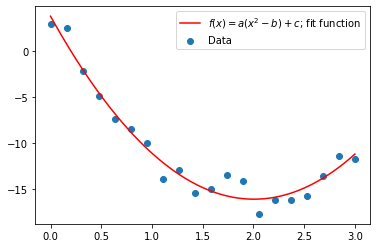

In [13]:
# Plot the dataset
_ = plt.scatter(x_data, y_data, label='Data')

# Overplot the fit function
_ = plt.plot(x_model, y_model, color='r', label=r'$f(x) = a(x^2 - b) + c$; fit function')

_ = plt.legend(loc='upper right')

Έχοντας το θεωρητικό μοντέλο που περιγράφει τα δεδομένα μας καθώς και το $1\sigma$-σφάλμα αυτών των παραμέτρων, μπορούμε να συμπεριλάβουμε και το **διάστημα εμπιστοσύνης** (confidence levels) της καμπύλης προσαρμογής. Ας υποθέσουμε ότι θέλουμε να κατασκευάσουμε το διάστημα εμπιστοσύνσης που αντιστοιχεί σε δύο τυπικές αποκλίσεις από τη μέση τιμή ($2\sigma$ confidence levels).

Σε αυτή την περίπτωση το άνω/κάτω όριο θα απέχει από τη μέση τιμή δύο φορές την τυπική απόκλιση που πήραμε από τον πίνακα συνδιακύμανσης. Έχοντας τα πάνω και κάτω όρια, μπορούμε απλά να γραμμοσκιάσουμε την περιοχή μεταξύ αυτών των τιμών.

In [14]:
nstd = 2. # number of standard deviations

popt_up = popt + nstd * p_sigma # the upper limit (+2sigma)
popt_low = popt - nstd * p_sigma # the lower limit (-2sigma)

# The x-y values for the 5-sigma upper/lower curves
y_fit_up = polynomial_model(x_model, *popt_up)
y_fit_low = polynomial_model(x_model, *popt_low)

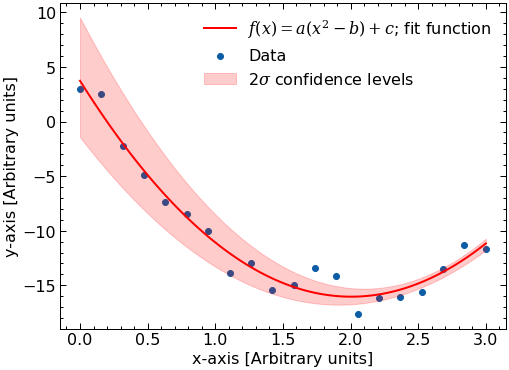

In [15]:
plt.style.use(['science', 'notebook'])

plt.xlabel('x-axis [Arbitrary units]')
plt.ylabel('y-axis [Arbitrary units]')

# Plot the dataset
_ = plt.scatter(x_data, y_data, label='Data')

# Overplot the fit function
_ = plt.plot(x_model, y_model, color='r', label=r'$f(x) = a(x^2 - b) + c$; fit function')

# Overplot the confidence levels
_ = plt.fill_between(x_model, y_fit_up, y_fit_low, alpha=0.2, color='r', label=r'2$\sigma$ confidence levels')

_ = plt.legend(loc='upper right')

Έτσι, καταλήγουμε στο συμπέρασμα ότι η αναλυτική σχέση (θεωρητικό μοντέλο) που περιγράφει το σύνολο των δεδομένων μας είναι η:

$$f(x) = 4.92 \pm 0.35 \left(x - 2.00 \pm 0.04 \right)^2 - 16.04 \pm 0.36$$

Χρησιμοποιώντας αυτό το θεωρητικό μοντέλο, μπορούμε τώρα να κάνουμε προβλέψεις για τιμές που δεν ανήκουν στο αρχικό σύνολο δεδομένων. Για παράδειγμα, για $x=0.2$ (τιμή που δεν αποτελεί μέρος των μετρήσεών μας) περιμένουμε σύμφωνα με το μοντέλο μας ότι $y= - 0.099$.

## Παραδείγματα

### Παράδειγμα 1: Φασματοσκοπία-γ και προσαρμογή Γκαουσιανής κατανομής

Σκοπός μας στην φασματοσκοπία-γ είναι η καταμέτρηση της έντασης της ακτινοβολίας που εκπέμπεται από μία πηγή ακτίνων γάμμα σαν συνάρτηση της ενέργειας των φωτονίων.

Σε αυτό το παράδειγμα θα δουλέψουμε με ένα σύνολο δεδομένων που περιέχει το φάσμα ακτίνων-γ μίας μονοενεργειακής πηγής ακτίνων-γ που λήφθηκε με κάποιον ανιχνευτή, συγκεκριμένα του ραδιοϊσοτόπου Καίσιο-137 (Cesium-137; Cs-137). 

Η πρώτη στήλη περιέχει τον αριθμό των καναλιών. Κάθε κανάλι αντιστοιχεί σε κάποιο συχνοτικό εύρος, άρα αυτή η στήλη ουσιαστικά εκφράζει την **ενέργεια** των φωτονίων.

Η δεύτερη στήλη περιέχει τον **αριθμό των γεγονότων** που κατέγραψε ο ανιχνευτής για κάθε ένα από αυτά τα κανάλια. Τις άλλες στήλες μπορείτε να τις αγνοήσετε.

In [16]:
cs_spectrum = pd.read_csv('data/cs137_spectrum.txt', delimiter='\t')
cs_spectrum.tail(5)

,Channel,Cs137,A,B,C
2043,2043,0,2,0,41
2044,2044,0,5,0,46
2045,2045,0,6,0,36
2046,2046,0,4,1,33
2047,2047,0,4,1,33


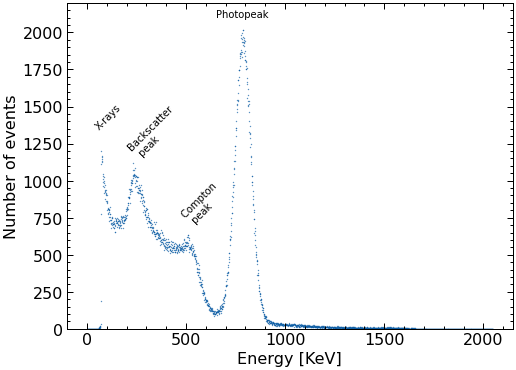

In [17]:
plt.xlabel('Energy [KeV]')
plt.ylabel('Number of events')

plt.ylim(top=2200)

_ = plt.scatter(cs_spectrum['Channel'], cs_spectrum['Cs137'], s=0.1)

_ = plt.text(32, 1350, 'X-rays', rotation=45)
_ = plt.text(200, 1150, 'Backscatter \n peak', rotation=45)
_ = plt.text(470, 700, 'Compton \n peak', rotation=45)
_ = plt.text(650, 2100, 'Photopeak')

Η μεγαλύτερη κορυφή που εμφανίζεται στο φάσμα αντιστοιχεί σε ολική απορρόφηση της ενέργειας των αρχικών ακτίνων-γ και ονομάζεται **φωτοκορυφή**. Χωρίς να μπούμε σε λεπτομέρειες που περιγράφουν την πυρηνική φυσική και τις αλληλεπιδράσεις των σωματιδίων με τον ανιχνευτή, θα αρκεστούμε στο να αναφέρουμε ότι:

- Η **μέση τιμή** της κορυφής μας δίνει πληροφορίες για την ενέργεια των φωτονίων που εκπέμφθηκαν.

- Το **πλάτος (width) της κορυφής** μας δίνει πληροφορίες για την ανάλυση (resolution) του ανιχνευτή.


Συνήθως, κορυφές αυτής της μορφής προσπαθούμε να τις προσεγγίσουμε με μία κατανομή Gauss

$$f(x, A, \mu,  \sigma) = A e^{-(x-\mu)^2/\sigma^2}$$

και να χρησιμοποιήσουμε τις παραμέτρους προσαρμογής $\mu$ και $\sigma$ για να αντλήσουμε πληροφορίες για τις ποσότητες που αναφέραμε πιο πάνω.

In [18]:
def gauss_f(x,A,mu,sig):
    """A Gaussian fit function"""
    return A*np.exp(-(x-mu)**2/sig**2)

Θελουμε να επικεντρωθούμε μόνο στη φωτοκορυφή, άρα θα φιλτράρουμε τα δεδομένα μας ώστε να περιλαμβάνουν το εύρος στο οποίο εντοπίζεται η κορυφή που θέλουμε.

In [19]:
# The x-axis data
channels = cs_spectrum.loc[:,'Channel'][(cs_spectrum['Channel'] > 725) & (cs_spectrum['Channel'] < 850)]

# The y-axis data
counts = cs_spectrum.loc[:,'Cs137'][(cs_spectrum['Channel'] > 725) & (cs_spectrum['Channel'] < 850)]

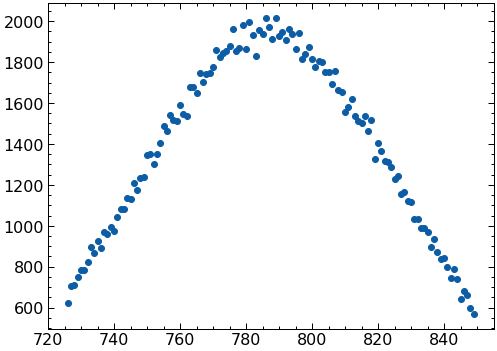

In [20]:
_ = plt.scatter(channels, counts)

Τώρα θα προσαρμόσουμε την καμπύλη Gauss στα δεδομένα μας. Σε αυτή την περίπτωση, όπως θα δούμε, πρέπει να δώσουμε εμείς κάποια αρχική εκτίμηση για τις παραμέτρους $A$, $\mu$ και $\sigma$, αλλιώς η python θα μας δώσει μία προειδοποίηση (warning) όπου θα μας ενημερώνει ότι η προσαρμογή δεν θα μπορέσει να γίνει.

Αυτό συμβαίνει γιατί η συνάρτηση ``curve_fit`` δεν μπορεί να υπολογίσει την αβεβαιότητα (διακύμανση) στις παραμέτρους προσαρμογής. Επειδή η συνάρτηση ``curve_fit`` προσπαθεί να βρει τις τιμές αυτών των παραμέτρων προσαρμογής *επαναληπτικά*, το πιο πιθανό είναι να μην μπορεί να ελαχιστοποιήσει τις παραγώγους που δίνουν το σφάλμα στην προσαρμογή σε κάθε βήμα. Έτσι, χωρίς να ξέρει αν το σφάλμα στην εκτίμηση μειώνεται ή αυξάνεται σε κάθε επανάληψη, δεν μπορεί να αποφασίσει με ποιόν τρόπο να αλλάξει τις τιμές των παραμέτρων.

Για να αποκτήσουμε μία διαίσθηση των τιμών που πρέπει να αρχικοποιήσουμε, κοιτάμε το διάγραμμα. Παρατηρούμε ότι το μέγιστο ύψος της καμπύλης είναι $A \simeq 2000$, η μέση τιμή της ενέργειας που αντιστοιχεί σε αυτό το πλάτος είναι $\mu \simeq 790$ και το πλάτος είναι $\sigma \simeq {\rm FWHM} \simeq 90$.

Μπορούμε να χρησιμοποιήσουμε τιμές κοντά σε αυτές ως αρχική εκτίμηση για τις παραμέτρους προσαρμογής.

In [21]:
A_init_guess = np.max(counts)
mu_init_guess = channels.iloc[np.argmax(counts)]

# A mask to find the indeces where counts = max/2 (half max)
FWHM_mask = np.where(np.isclose(counts, A_init_guess/2., 0.018))

# The width at half max
sigma_init_guess = np.diff(channels.iloc[FWHM_mask].values)

print("Initial guess:\n---\nA = %.0f, mu = %.0f, sigma = %.0f" % (A_init_guess, mu_init_guess, sigma_init_guess))

Initial guess:
---
A = 2018, mu = 789, sigma = 94


In [22]:
popt, pcov = so.curve_fit(gauss_f, channels, counts, p0=[2000, 790, 90])

In [23]:
popt

array([1939.55510395,  786.33851861,   57.78717217])

In [24]:
A_opt, mu_opt, sig_opt = popt
x_model = np.linspace(min(channels), max(channels), 1000)
y_model = gauss_f(x_model, A_opt, mu_opt, sig_opt)

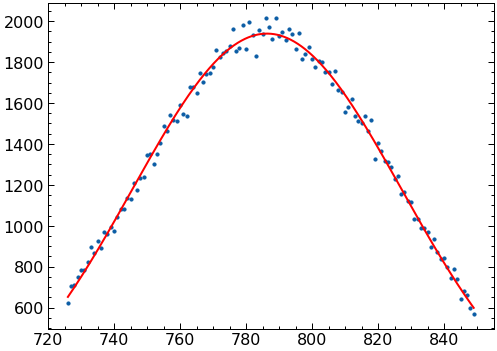

In [25]:
_ = plt.scatter(channels, counts, s=10)
_ = plt.plot(x_model, y_model, color='r', lw=2.0)

In [26]:
print("A = %f +/- %f" % (popt[0], np.sqrt(pcov[0][0])))
print("mu = %f +/- %f" % (popt[1], np.sqrt(pcov[1][1])))
print("sigma = %f +/- %f" % (popt[2], np.sqrt(pcov[2][2])))

A = 1939.555104 +/- 5.702578
mu = 786.338519 +/- 0.144019
sigma = 57.787172 +/- 0.264272


### Παράδειγμα 2: Μετρήσεις με σφάλματα

Υποθέστε ότι οι μετρήσεις στον αριθμό των γεγονότων που χρησιμοποιήσαμε στο σύνολο δεδομένων του Παραδείγματος 1, έχουν σφάλμα που δίνεται από τη σχέση: $\delta_{y_i} = \sqrt{y_i}$, για κάθε σημείο $y_i$.

In [27]:
yerr_data = np.sqrt(counts)

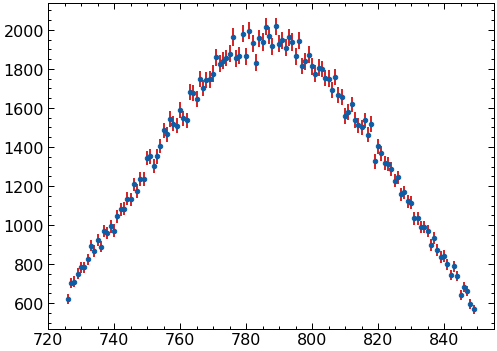

In [28]:
_ = plt.errorbar(channels, counts, yerr_data, ls='', color='tab:red')
_ = plt.scatter(channels, counts, s=20, zorder=1000)

Μπορούμε, πάλι, να εκτιμήσουμε τη μέγιστη πιθανότητα (maximum-likelihood) των τιμών των παραμέτρων προσαρμογής με τη βοήθεια της συνάρτησης ``curve_fit``.

In [29]:
popt, pcov = so.curve_fit(gauss_f, channels, counts, sigma=yerr_data, p0=[2000, 790, 90])
popt

array([1936.83040653,  786.29515452,   57.88161245])

Προσέξτε ότι τώρα η απάντηση διαφέρει ελαφρώς από αυτή του Παραδείγματος 1. Εάν όλα τα $\delta_{y_i}$ είναι τα ίδια τότε η απάντηση δεν θα διέφερε από την περίπτωση των δεδομένων χωρίς σφάλματα.

### Παράδειγμα 3: Διαμοριακές αλληλεπιδράσεις

Το δυναμικό Lennard-Jones είναι ένα δυναμικό που περιγράφει τις αλληλεπιδράσεις μεταξύ ενός ζεύγους μοριών (για περισσότερες πληροφορίες [δες εδώ](https://en.wikipedia.org/wiki/Lennard-Jones_potential)).

Το συγκεκριμένο δυναμικό δίνεται από τη σχέση:

$$V(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]$$

Το ζητούμενο είναι να βρούμε τις βέλτιστες τιμές για τα $\sigma$ και $\epsilon$ ώστε το δυναμικό να περιγράφει το καλύτερο δυνατόν τα δεδομένα μας.

In [30]:
r_data, V_data = np.loadtxt('data/LJ_potential.txt')

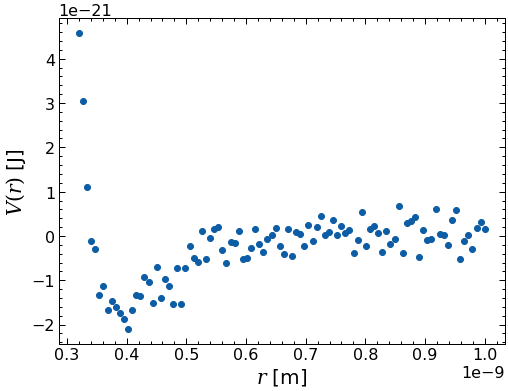

In [31]:
plt.xlabel('$r$ [m]', fontsize=20)
plt.ylabel('$V(r)$ [J]', fontsize=20)

_ = plt.scatter(r_data, V_data)

Παρατηρώντας το διάγραμμα βλεπουμε ότι οι άξονες περιγράφουν μεγάλους αριθμούς οπότε θα ήταν καλή ιδέα να επαναπροσδιορίσουμε τη κλίμακα του γραφήματος.

- Θα πολλαπλασιάσουμε τις τιμές στον $x$-άξονα με ``1e9``. Έτσι, η διάσταση του άξονα θα μετατραπεί από **μέτρα** σε **νανόμετρα**.

- Θα διαιρέσουμε τις τιμές στον $y$-άξονα με τη σταθερά του Boltzmann: $k_B = 1.3806452 \times 10^{-23}\;\;\text{J/K}$. Έτσι, η διάσταση του άξονα θα μετατραπεί από **Joules** σε **Kelvin**.

In [32]:
r_data*=1e9
V_data/=1.38e-23

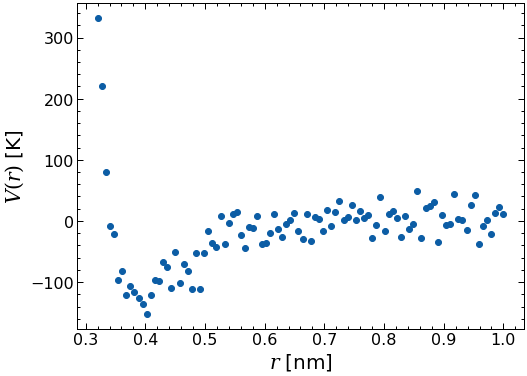

In [33]:
plt.xlabel('$r$ [nm]', fontsize=20)
plt.ylabel('$V(r)$ [K]', fontsize=20)

_ = plt.scatter(r_data, V_data)

Για να μπορέσουμε να προσαρμόσουμε την καμπύλη του δυναμικού στα δεδομένα μας, πρέπει πρώτα να εντοπίσουμε κάποια βασικά σημεία που περιγράφουν το δυναμικό. Αυτά θα μας βοηθήσουν να επιλέξουμε κατάλληλες αρχικές τιμές για τις παραμέτρους προσαρμογής.

Από τη [Wikipedia](https://en.wikipedia.org/wiki/Lennard-Jones_potential) βρίσκουμε ότι:

- Το ελάχιστο του δυναμικού είναι για $r\equiv r_{\rm min}=2^{1/6}\sigma$

- Στο ελάχιστο, η τιμή του δυναμικού είναι: $V(r_{\rm min}) = -\epsilon$

In [34]:
def LJ_potential(r, sigma, epsilon):
    """The Lennard-Jones potential"""
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

Από το διάγραμμα βλέπουμε ότι το δυναμικό γίνεται ελάχιστο για $r_{\rm min} \simeq 0.4$ nm, ενώ η τιμή του είναι $V(r_{\rm min}) \simeq - 152$ K. Γνωρίζοντας αυτά τα δύο, μπορούμε να επιλέξουμε αρχικές τιμές για τα $\epsilon$ και $\sigma$.

In [35]:
# eps_init_guess = 120
# sig_init_guess = 2**(-1/6) * 0.4

# Initial guess for epsilon, sigma
eps_init_guess = -np.min(V_data)
sig_init_guess = 2**(-1/6) * r_data[np.argmin(V_data)]

Προσαρμόζουμε τη θεωρητική καμπύλη στα δεδομένα.

In [36]:
popt, pcov = so.curve_fit(LJ_potential, r_data, V_data, p0=[sig_init_guess, eps_init_guess])
sig_opt, eps_opt = popt

Κατασκευάζουμε ένα εύρος τιμών για τον $x$-άξονα για το θεωρητικό μοντέλο καθώς και τις αντίστοιχες τιμές του $y$-άξονα που προκύπτουν από τη θεωρητική συνάρτηση.

In [37]:
r_model = np.linspace(min(r_data), max(r_data), 1000)
V_model = LJ_potential(r_model, sig_opt, eps_opt)

Φτιάχνουμε το διάγραμμα όπου φαίνονται τα δεδομένα μας μαζί με την καμπύλη προσαρμογής

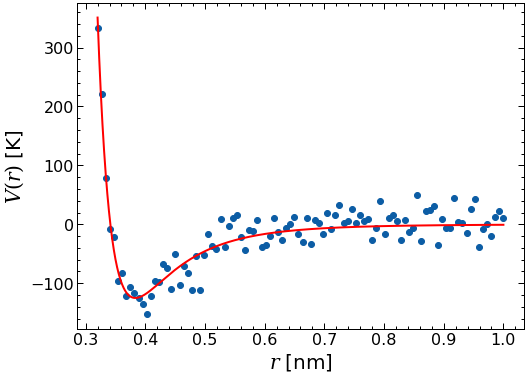

In [38]:
plt.xlabel('$r$ [nm]', fontsize=20)
plt.ylabel('$V(r)$ [K]', fontsize=20)

# Plot the data
_ = plt.scatter(r_data, V_data)

# Overplot the fitting function
_ = plt.plot(r_model, V_model, color='r')

In [39]:
print("The optimum values are: sigma = {}, epsilon = {}".format(round(sig_opt,2), round(eps_opt,2)))

The optimum values are: sigma = 0.34, epsilon = 124.99
